In [27]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.ensemble import StackingClassifier
# from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import sklearn.metrics as metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score,roc_auc_score,recall_score,classification_report,mean_squared_error,accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [28]:
train=pd.read_csv("../input/petadoption-mod/train_mod.csv")
test=pd.read_csv("../input/petadoption-mod/test_mod.csv")



#label encoding the features for the modelling process
le=LabelEncoder()
le.fit(train["color_type"])
# train["color_type"]=le.fit_transform(train["color_type"])
train["color_type"]=le.transform(train["color_type"])
test["color_type"]=le.transform(test["color_type"])

In [29]:
#some feature engineering
train["len_in_cm"]=train["length(m)"]*100
test["len_in_cm"]=test["length(m)"]*100


train["X1_X2"]=train["X1"]*train["X2"]
test["X1_X2"]=test["length(m)"]*test["X2"]


train["Area_occupied"]=train["len_in_cm"]*train["height(cm)"]
test["Area_occupied"]=test["len_in_cm"]*test["height(cm)"]

train_set,val_set=train_test_split(train,test_size=.25,random_state=42)
train_set.shape,val_set.shape

#-------------------------------------------------------------------------------
#train_set
train_data=train_set.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed']
                          ,axis=1)
train_res_breed=train_set.breed_category
train_res_pet=train_set.pet_category

#-------------------------------------------------------------------------------
#val_set
val_data=val_set.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed'],
                     axis=1)
val_res_breed=val_set.breed_category
val_res_pet=val_set.pet_category
#-------------------------------------------------------------------------------
train_full=train.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed']
                          ,axis=1)
train_full_breed=train.breed_category
train_full_pet=train.pet_category
test_full=test.drop(['pet_id', 'issue_date', 'listing_date','days_stayed']
                          ,axis=1)

#-------------------------------------------------------------------------------

train_data.shape,train_res_breed.shape,val_data.shape,val_res_breed.shape,train_full.shape,test_full.shape

((14125, 12), (14125,), (4709, 12), (4709,), (18834, 12), (8072, 12))

In [30]:
lrc = LogisticRegression()
rfc=RandomForestClassifier()
adbc=AdaBoostClassifier()
bgc=BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bgcl_lrc = BaggingClassifier(base_estimator=lrc, random_state=42)
ab_rfc = AdaBoostClassifier(base_estimator=rfc,random_state=42)
ab_dtc = AdaBoostClassifier(base_estimator=dtc,random_state=42)
ab_nbc=  AdaBoostClassifier(base_estimator=gnb,random_state=42)
ab_lrc=  AdaBoostClassifier(base_estimator=lrc,random_state=42)
gbc=GradientBoostingClassifier()
ab_gbc=  AdaBoostClassifier(base_estimator=gbc,random_state=42)
xgbc=XGBClassifier()
ab_xgbc=  AdaBoostClassifier(base_estimator=xgbc,random_state=42)
lgbc=LGBMClassifier()
cat=CatBoostClassifier()

In [31]:
models=[rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,ab_rfc,ab_dtc,ab_nbc,ab_lrc,gbc,ab_gbc,xgbc,ab_xgbc,lgbc]
sctr,scte,auc,ps,rs=[],[],[],[],[]
def ensemble_for_train_val(X_train,y_train,X_test, y_test):
    for model in models:
        print(model.__class__.__name__)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_pred_new=model.predict_proba(X_test)
        y_test_pred_new=y_test_pred_new[:,1]
        train_score=model.score(X_train,y_train)
        test_score=model.score(X_test,y_test)
        p_score=metrics.precision_score(y_test,y_test_pred,average='micro')
        r_score=metrics.recall_score(y_test,y_test_pred,average='micro')
        
        sctr.append(train_score)
        scte.append(test_score)
        ps.append(p_score)
        rs.append(r_score)
    return sctr,scte,ps,rs




In [32]:
# # checking the performance on train and validation
# ensemble_for_train_val(train_data,train_res_breed, val_data, val_res_breed)
# # 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'

# ensemble=pd.DataFrame({'names':['Random Forest','Ada boost','Bagging',
#                                 'Naive-Bayes','KNN','Decistion Tree',
#                                 'bagged LR',"adaboost rf","adaboost dtc","adaboost naive bayes",
#                                 "adaboost logistic regression","gradient boosting trees"
#                                 ,"adaboost gbc","xgboost","adaboost xgbc","lgbc"],
#                        'training':sctr,'testing':scte,'precision':ps,'recall':rs,})

# ensemble=ensemble.sort_values(by='precision',ascending=False).reset_index(drop=True)
# ensemble

In [33]:
# models=[lgbc]
# ensemble_for_train_val(train_data,train_res_breed, val_data, val_res_breed)

# ensemble1=pd.DataFrame({'names':['lgbc'],
#                        'training':sctr,'testing':scte,'precision':ps,'recall':rs,})
# # ensemble=ensemble.sort_values(by='precision',ascending=False).reset_index(drop=True)
# ensemble1

models=[lgbc]

# ensemble_for_train_val(train_full,train_full_breed, train_full_pet, test_full)

def pred_on_full_data(Xtrain,ytrain,ytrain2,Xtest,models):
    for model in models:
        print(model.__class__.__name__)
        model.fit(Xtrain, ytrain)
        y_test_pred_breed = model.predict(Xtest)
        model.fit(Xtrain, ytrain2)
        y_test_pred2_pet=model.predict(Xtest)
        id=pd.Series(test["pet_id"])
        submission=pd.DataFrame({'pet_id':id,'breed_category':y_test_pred_breed,'pet_category':y_test_pred2_pet})
#         predictions=pd.concat([test['INCIDENT_ID'],pd.DataFrame(y_test_pred,columns=['MULTIPLE_OFFENSE'])],1)
        a="submission_multiple_"+model.__class__.__name__+"submission.csv"
        submission.to_csv(a,index=False)
        

#getting predictions on full data
pred_on_full_data(Xtrain=train_full,ytrain=train_full_breed,ytrain2=train_full_pet,Xtest=test_full,models=models)


LGBMClassifier


In [34]:
def plot_graph(a):
    plt.figure(figsize=(8,6))
    chart=sns.barplot(x=a["name_of_column"],y=a["feature_importance"])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()
def feature_importance_plot_rev(dataframe,classifier,limit_of_the_importance):
    x=list(zip(dataframe.columns,classifier.feature_importances_))
    xx=pd.DataFrame(x)
    xx.columns=["name_of_column","feature_importance"]
    xx=xx.sort_values("feature_importance",ascending=False)
    xx=xx[xx["feature_importance"]>limit_of_the_importance]
    plot_graph(xx)
    return xx

# models=[lgbc]
# for model in models:
#     print(model)
#     features=feature_importance_plot_rev(train_full,model,-1000)
    
#     print(model.__class__.__name__)

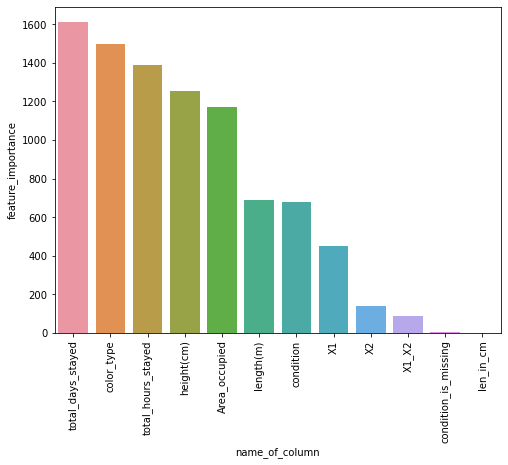

6        total_days_stayed
1               color_type
7       total_hours_stayed
3               height(cm)
11           Area_occupied
2                length(m)
0                condition
4                       X1
5                       X2
10                   X1_X2
8     condition_is_missing
9                len_in_cm
Name: name_of_column, dtype: object

In [35]:
lgbc.fit(train_full,train_full_breed)
important_features_breed=feature_importance_plot_rev(train_full,lgbc,-1000)
important_features_breed["name_of_column"]

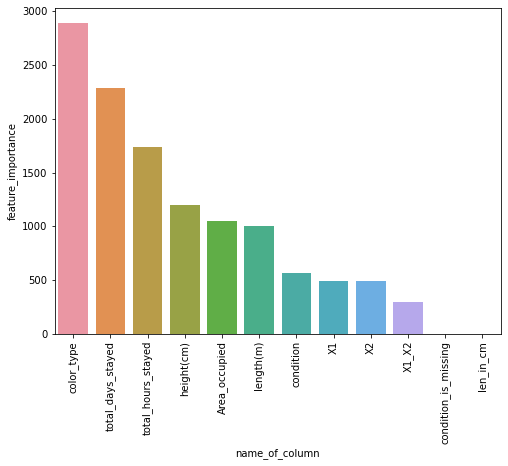

1               color_type
6        total_days_stayed
7       total_hours_stayed
3               height(cm)
11           Area_occupied
2                length(m)
0                condition
4                       X1
5                       X2
10                   X1_X2
8     condition_is_missing
9                len_in_cm
Name: name_of_column, dtype: object

In [36]:

lgbc.fit(train_full,train_full_pet)
important_features_pet=feature_importance_plot_rev(train_full,lgbc,-1000)
important_features_pet["name_of_column"]

In [38]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('gbc', GradientBoostingClassifier()))
    level0.append(("lgbc",LGBMClassifier()))
    # define meta learner model
    level1 = GaussianNB()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
# get a list of models to evaluate
def get_models():
	models = dict()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
	return scores

models_stacked = get_stacking()

models=[models_stacked]

# ensemble_for_train_val(train_full,train_full_breed, train_full_pet, test_full)

def pred_on_full_data(Xtrain,ytrain,ytrain2,Xtest,models):
    for model in models:
        print(model.__class__.__name__)
        model.fit(Xtrain, ytrain)
        y_test_pred_breed = model.predict(Xtest)
        model.fit(Xtrain, ytrain2)
        y_test_pred2_pet=model.predict(Xtest)
        id=pd.Series(test["pet_id"])
        submission=pd.DataFrame({'pet_id':id,'breed_category':y_test_pred_breed,'pet_category':y_test_pred2_pet})
#         predictions=pd.concat([test['INCIDENT_ID'],pd.DataFrame(y_test_pred,columns=['MULTIPLE_OFFENSE'])],1)
        a="submission_multiple_stacked"+model.__class__.__name__+"submission.csv"
        submission.to_csv(a,index=False)
        

#getting predictions on full data
pred_on_full_data(Xtrain=train_full,ytrain=train_full_breed,ytrain2=train_full_pet,Xtest=test_full,models=models)



# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, train_full, train_full_breed)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

dict


AttributeError: 'dict' object has no attribute 'fit'